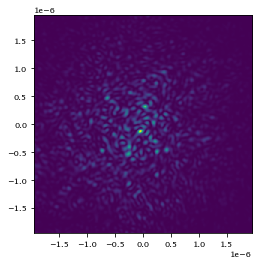

In [11]:
import sys
sys.path.append("..")
from hcipy.hcipy import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

D_tel = 8.2 # meter
wavelength = 500e-9
k = 2 * np.pi / wavelength
size_pupil = 512
q, airy = 8, 32
pupil_grid = make_pupil_grid(size_pupil, D_tel)
focal_grid = make_focal_grid_from_pupil_grid(pupil_grid, q=q, num_airy=airy, wavelength=wavelength)
size_focal = focal_grid.shape[0]
prop = FraunhoferPropagator(pupil_grid, focal_grid)
aperture = circular_aperture(D_tel)(pupil_grid)
fried_parameter = 0.2 # meter
outer_scale = 20 # meter
velocity = 10 # meter/sec
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)
wf = Wavefront(aperture, wavelength)
img = prop(layer(wf)).intensity
imshow_field(img)

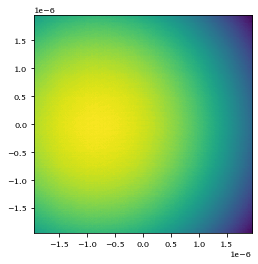

In [13]:
def make_star(i, j, cutoff=1e-3, spread=1, offset=(0, 0)):
    center = pupil_grid.shape//2 - offset
    intensity = np.exp(-np.sum((np.array([i, j]) - center)**2)/spread)
    if intensity > cutoff:
        return intensity
    return 0.0

star = np.fromfunction(np.vectorize(make_star), pupil_grid.shape)
wf_star = Wavefront(Field(star.flatten(), pupil_grid))
'''imshow_field(wf.intensity)
plt.show()'''

img_star = prop.forward(layer(wf_star)).intensity
imshow_field(img_star)
plt.show()

In [3]:
def center_of_mass(f):
    # takes in a Field, returns its CM.
    # rewriting because there seem to be weird bugs with the scipy inbuilt
    s = f.grid.shape[0]
    x, y = (n.flatten() for n in np.meshgrid(np.linspace(-s/2, s/2, s), np.linspace(-s/2, s/2, s)))
    return np.array((sum(f*x), sum(f*y)))/sum(f)

subgrid = make_pupil_grid(size_focal//2, D_tel/2)
subimage_creator = lambda img, size: [img[:size//2, :size//2], img[:size//2, size//2:],
                                 img[size//2:, :size//2], img[size//2:, size//2:]]
            # top left, top right, bottom left, bottom right
    
subimages_star = subimage_creator(star, size_pupil)
star_avgs = [np.mean(quad) for quad in subimages_star]

In [4]:
norm = sum(star_avgs) / 4
I_x = float(sum(p * i for p, i in zip(star_avgs, (1, -1, 1, -1))) / norm)
I_y = float(sum(p * i for p, i in zip(star_avgs, (1, 1, -1, -1))) / norm)

print([I_x, I_y])
print(center_of_mass(img.ravel()) / size_pupil)

[-1.3034283066383632, -1.3034283066383632]
[ 0.00035557 -0.02740406]
